<a href="https://colab.research.google.com/github/nasrinsaalehi/Drawning-Detection-/blob/main/01_My_Pytorch_Workflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
import torch
import matplotlib.pyplot as plt
from torch import nn 


Lets make the data using linear regression

In [168]:
weight= 0.7
bias= 0.3

X= torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y= weight * X+ bias

Lets Creat a Training and test set with our data


In [169]:
# Creat a train and test split
train_split = int(0.8* len(X))
X_train, y_train= X[:train_split], y[:train_split]
X_test, y_test= X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [170]:
def plt_predictions(train_data= X_train,
                    train_labels= y_train,
                    test_data= X_test,
                    test_labels= y_test,
                    predictions= None):
  """
  Plots training data, test data and compares predictions if available
  """
  plt.figure(figsize= (10,7))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s= 4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label= "Test data")

  # Are there any predictions?
  if predictions is not None:
    # Plot the predictions of they exist 
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend: shows the labels on the plot
  plt.legend(prop= {"size":14});

### 2. Build the model

In [171]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):
  # almost everything in pytorch inherrits from nn.module class
  def __init__(self):
    super().__init__()
    self.weight= nn.Parameter(torch.randn(1,
                                        requires_grad=True,
                                        dtype= torch.float))
    self.bias= nn.Parameter(torch.randn(1,
                                        requires_grad= True,
                                        dtype= torch.float))
    
  #Forward method to defining the computaion in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # "x" is the input data that is expected to be a torch.Tensor
    # the model outputs a torch.Tensor
    return self.weight * x + self.bias

In [172]:
# Create an instant of our model (a subclass of nn.Module)
model_0= LinearRegressionModel()

# chech the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [173]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [174]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

# Making prediction using `torch.inference_mode()`

To check our model's predictive power, lets see how well predics `y_test` based on `X_test`.
when we pass data through our model, its going to run it through the `forward()` method


In [175]:
# Make predictions with model
with torch.inference_mode():
  y_preds= model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

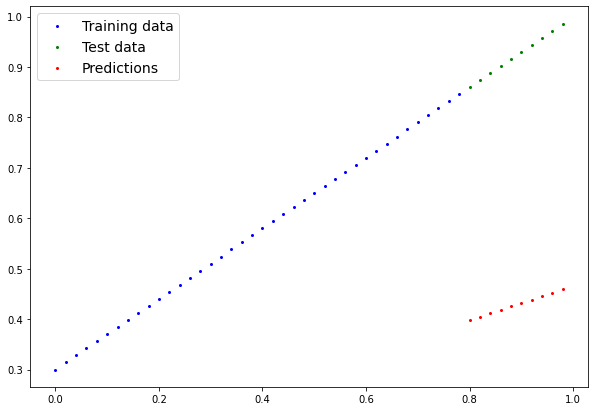

In [176]:
plt_predictions(predictions= y_preds)

In [177]:
with torch.no_grad():
  y_preds_same_as_inference_mode= model_0(X_test)

y_preds_same_as_inference_mode 

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

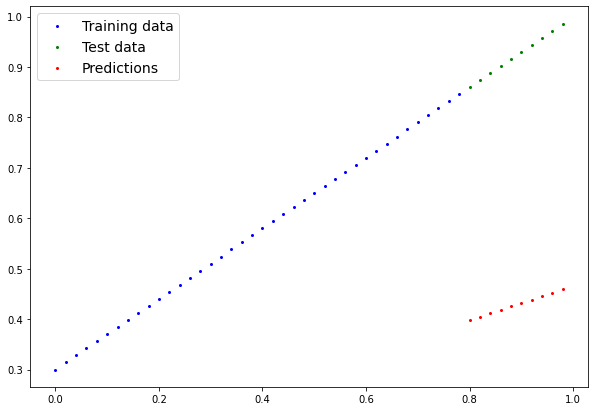

In [178]:
plt_predictions(predictions= y_preds_same_as_inference_mode)

### 3. Train the Model

The whole idea of training is for a model to move from some unnown parameters *these may be randoms) to some known parameters.

Or in other words froma poor representation of data to a better representation of the data.

One way to messure how poor  yoru model predictions are, is to use a loss function.
* Note : Los function may also be called cost fuciton or  criterrion in different areas. for our case, we are going to refer to refer it as loss function.

Things we need to train the model:

* **Loss Function:** A function to measure how wron your model's prediction are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of the model and adjusts the model's parameters (e.g. weight and bias) to improve the function.

  inside the optimizer we need to set some parametrs:
  1. model parameter that we need to optimize (model_0, parameters())
  2. learning rate of the model


And specifically for PyTorch we need:
* a training loop
* a testing loop

In [179]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [180]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [181]:
# Set up a Loss function
loss_fn= nn.L1Loss()

# Set up an Optimizer (stochastic gradient descent)
optimizer= torch.optim.SGD(params= model_0.parameters(),
                           lr= 0.001) # learning rate= possibly the most important hyper parameter of the model


### Building a training Loop (and a testing loop) in PyTorch

A couple of things we need for a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` funstions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground trth labels)
3. Optimizer zero grad
4. Loss backward- move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [182]:
torch.manual_seed(42)
# An epoch is one loop through the data (this is a hyper parameter bc. we built it ourselves)
epochs= 2000

# Track different values for different models with different parameters
epoch_count= []
loss_values= []
test_loss_values= []

### training
# 0. Loop through the data
for epoch in range(epochs):
  
  # Set the model to trainig mode
  model_0. train() # train mode in pytorch sets all parameters that require gradients to require gradents
  
  # 1. Forward pass
  y_pred= model_0(X_train) # when we call the model actually it calls the forward method of the model
  
  # 2. Calculate the loss
  loss= loss_fn(y_pred, y_train)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropagation on the loss with respect to model parameters
  loss.backward()

  # 5. Step the optimizer (perfrom gradient descent)
  optimizer.step() # by default how the optimizer changes will accumilate through the loop so... we have to zero them above in step 3 for the next iteration of the loop
  
  ### Testing the model
  model_0.eval() # turns off different settings in the model not needed for evaluation/testin (dropout /batch norm)
  with torch.inference_mode(): # turns off gradient tracking and a couple more things behind th scenes
  #with torch.no_grad() # you may also see torch.no_grad() in older pytorxh codes
    # 1. Do the forward pass
    test_pred= model_0(X_test)

    #2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 100 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weight', tensor([0.3371])), ('bias', tensor([0.1298]))])
Epoch: 100 | Loss: 0.19767141342163086 | Test loss: 0.35847947001457214
OrderedDict([('weight', tensor([0.3761])), ('bias', tensor([0.2298]))])
Epoch: 200 | Loss: 0.08973254263401031 | Test loss: 0.22795839607715607
OrderedDict([('weight', tensor([0.4150])), ('bias', tensor([0.3257]))])
Epoch: 300 | Loss: 0.05357731133699417 | Test loss: 0.15086300671100616
OrderedDict([('weight', tensor([0.4485])), ('bias', tensor([0.3730]))])
Epoch: 400 | Loss: 0.04549176245927811 | Test loss: 0.11657620966434479
OrderedDict([('weight', tensor([0.4730])), ('bias', tensor([0.3855]))])
Epoch: 500 | Loss: 0.04160415381193161 | Test loss: 0.10088418424129486
OrderedDict([('weight', tensor([0.4924])), ('bias', tensor([0.3839]))])
Epoch: 600 | Loss: 0.03811401128768921 | Test loss: 0.08986451476812363
OrderedDict([('weight', tensor([0.5104])), ('bias', tensor([0.3789]

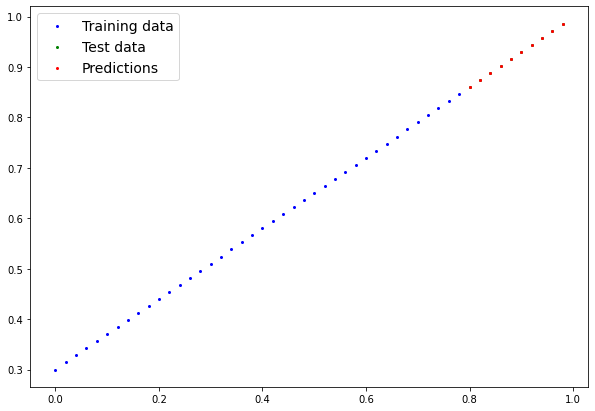

In [183]:
with torch.inference_mode():
  y_predictions_new= model_0(X_test)
  plt_predictions(X_train, y_train, X_test, y_test, predictions= y_predictions_new)

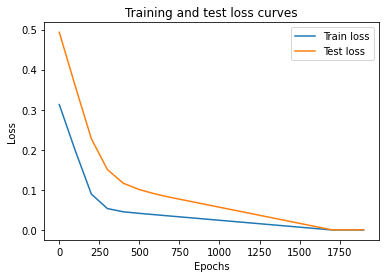

In [184]:
import numpy as np
# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label= "Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label= "Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Saving the model in PyTorch
There are three main methods yu should know about for saving and loading models in PyTorch.
1. `torch.save()` - allows you save a PyTorch object in PyTorch's pickle format
2. `torch.load()` - allows yo to load a saved pytorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary.
 

In [ ]:
# saving our pytorch model
from pathlib import path
